In [7]:
import os
from os import path
import numpy as np
import pandas as pd
from scipy.io import wavfile

from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [8]:
DATASET_PATH = '.\data_v_7_stc'
FS = 16000

In [9]:
TRAIN_DIR = path.join(DATASET_PATH, 'audio')
train_file = [f for f in os.listdir(TRAIN_DIR) if path.isfile(path.join(TRAIN_DIR, f))]
train_wave = [w for w in train_file if w[-4:] == '.wav']
train_wave[0], len(train_wave)

('background_0001.wav', 11307)

In [10]:
TEST_DIR = path.join(DATASET_PATH, 'test')
test_file = [f for f in os.listdir(TEST_DIR) if path.isfile(path.join(TEST_DIR, f))]
test_wave = [w for w in test_file if w[-4:] == '.wav']

test_tag_split = [(f.split('_'))[:-1] for f in test_wave]
test_tag_list = [ [tag for tag in tag_split if tag != 't'] for tag_split in test_tag_split]
test_tag = ['_'.join(tag_list) for tag_list in test_tag_list]
test_wave[223], test_tag[223]

('knocking_door_t_0010.wav', 'knocking_door')

In [11]:
df = pd.read_csv(path.join(DATASET_PATH, 'meta/meta.txt'), sep='\t', names=['File', '_', '__', 'Duration', 'Class'])
df.drop(['_', '__'], axis=1, inplace=True)
df.head()

,File,Duration,Class
0,background_0001.wav,9.458500,background
1,background_0001_time_stretch_0.wav,9.989070,background
2,background_0001_time_stretch_1.wav,9.879410,background
3,background_0001_time_stretch_10.wav,11.156553,background
4,background_0001_time_stretch_11.wav,13.261587,background


In [12]:
df_test = pd.DataFrame(np.concatenate((test_wave, test_tag)).reshape(-1, 2, order='F'), columns=['File', 'Class'])
df_test.head()

,File,Class
0,background_0001.wav,background
1,background_0004.wav,background
2,background_0009.wav,background
3,background_0012.wav,background
4,background_0016.wav,background


In [14]:
tags = np.unique(test_tag)
d_class = dict(zip(tags, range(tags.shape[0])))
d_class_inv = {val:key for key, val in d_class.items()}

In [9]:
#fs, data = wavfile.read(path.join(TRAIN_DIR, 'ring_0083.wav'))
fs, data = wavfile.read(path.join(TRAIN_DIR, 'knocking_door_0001.wav'))

In [574]:
#fs, data = wavfile.read(path.join(TRAIN_DIR, 'background_0003_time_stretch_1.wav'))
#fs, data = wavfile.read(path.join(TRAIN_DIR, 'background_0004.wav'))
#fs, data = wavfile.read(path.join(TRAIN_DIR, 'bg_0017.wav'))
#fs, data = wavfile.read(path.join(TRAIN_DIR, 'tool_0209.wav'))
fs, data = wavfile.read(path.join(TRAIN_DIR, 'tool_0192.wav'))

In [15]:
def scaler(data, maximum=2**15 - 1):
    scale = maximum / max(abs(data))
    return np.array(data*scale, dtype=data.dtype)

In [11]:
data_scaled = scaler(data)

In [16]:
def std_average(data, window):
    N = data.shape[0]
    W = int(window)
    HW = int(window // 2)
    if (N <= W):
        return np.array([data.mean()], dtype=data.dtype)
    
    data_std  = np.zeros(int((2*(N//W + 1)),), dtype=data.dtype)
    
    data_std[0] = data[:HW].std()
    for i in range(data_std.shape[0] - 2):
        data_std[i+1] = data[i*HW:(i+2)*HW].std()
    data_std[-1] = data[-HW:].std()

    return data_std

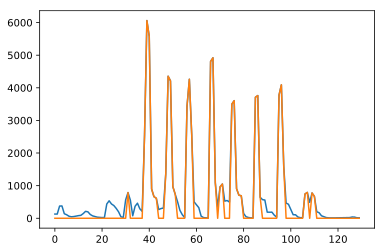

In [13]:
data_std = std_average(data_scaled, fs//10)
plt.plot(range(data_std.shape[0]), data_std);
data_std[data_std <= max(data_std)/10] = 0
plt.plot(range(data_std.shape[0]), data_std);

In [17]:
def signal_detector(data, window, min_duration_frame, scale=10):
    data_std = std_average(data, window)
    
    std_filter = np.zeros(data_std.shape, dtype='bool')
    std_filter[data_std > max(data_std)/scale] = True
       
    while (all(std_filter)):
        scale /= 2
        std_filter = np.zeros(data_std.shape, dtype='bool')
        std_filter[data_std > max(data_std)/scale] = True
        
    if (not any(std_filter)):
        return []
    
    HW = window//2
    signal_frame = []
    front = np.argwhere(std_filter).reshape(-1,)[0]
    back = 0
    is_signal = std_filter[0]
    signal_duration = 0
    silence_duration = 0
    for i, flag in enumerate(std_filter):
        if (flag and not is_signal):
            silence_duration = (i - back + 1)*HW
            is_signal = True
            if (silence_duration > min_duration_frame):
                if (signal_duration >= min_duration_frame):
                    signal_frame.append((max(0,             (front-1)*HW),
                                         min(data.shape[0], (back   )*HW)))
                front = i     
        if (not flag and is_signal):
            back = i
            is_signal = False
            signal_duration = (back - front + 1)*HW
            
    if (std_filter[-1]):
        signal_frame.append((max(0,(front-1)*HW), data.shape[0]))
    else:
        signal_frame.append((max(0,             (front-1)*HW),
                             min(data.shape[0], (back   )*HW)))     
    
    return signal_frame

In [845]:
signal_part = signal_detector(np.array([0,0,0,0,10,-10,0,0]), 4, 2, 10)
signal_part

[0 0 7 7 0 0]
[False False  True  True False False]


[(2, 8)]

In [15]:
signal_part = signal_detector(data_scaled, fs//10, fs//10, 10)
signal_part

[(24000, 25600),
 (29600, 35200),
 (36800, 41600),
 (44000, 47200),
 (52000, 57600),
 (59200, 64000),
 (67200, 70400),
 (75200, 78400),
 (84000, 88800)]

In [18]:
def oscilogram_feature(data_scaled, signal_part):
    if (len(signal_part) == 0):
        return np.std(data_scaled), np.median(data_scaled**2), 1, 0
    
    N = data_scaled.shape[0]
    signal_data = np.ndarray((0,))
    signal_duration = 0
    for front, back in signal_part:
        signal_data = np.concatenate((signal_data, data_scaled[front:back]))
        signal_duration += back - front
    std_median = np.std(signal_data)
    power_median = np.median(signal_data**2)
    ratio = signal_duration / N
    part_count = len(signal_part)
    return std_median, power_median, ratio, part_count

In [19]:
for column in ('std_median', 'power_median', 'ratio', 'part_count'):
    df[column] = 0
    df_test[column] = 0
df.head()

,File,Duration,Class,std_median,power_median,ratio,part_count
0,background_0001.wav,9.458500,background,0,0,0,0
1,background_0001_time_stretch_0.wav,9.989070,background,0,0,0,0
2,background_0001_time_stretch_1.wav,9.879410,background,0,0,0,0
3,background_0001_time_stretch_10.wav,11.156553,background,0,0,0,0
4,background_0001_time_stretch_11.wav,13.261587,background,0,0,0,0


In [20]:
def populate(DIR, file_name):
    fs, data = wavfile.read(path.join(DIR, file_name))
    data_scaled = scaler(data)
    signal_part = signal_detector(data_scaled, fs//10, fs//10, 10)
    std_median, power_median, ratio, part_count = oscilogram_feature(data_scaled, signal_part)
    return pd.Series([std_median, power_median, ratio, part_count], index=['std_median', 'power_median', 'ratio', 'part_count'])

In [25]:
df.loc[:5, ['std_median', 'power_median', 'ratio', 'part_count']] = df[:5].apply(lambda row: populate(TRAIN_DIR, row['File']), axis=1)
df.head(10)

,File,Duration,Class,ratio,part_count,std_median,power_median
0,background_0001.wav,9.458500,background,0.433473,5.0,1807.158625,416025.0
1,background_0001_time_stretch_0.wav,9.989070,background,0.405259,6.0,1951.477688,614656.0
2,background_0001_time_stretch_1.wav,9.879410,background,0.404699,6.0,1773.018809,485809.0
3,background_0001_time_stretch_10.wav,11.156553,background,0.403167,7.0,1935.027203,695556.0
4,background_0001_time_stretch_11.wav,13.261587,background,0.403238,7.0,1921.164951,732736.0
5,background_0001_time_stretch_12.wav,9.186440,background,NaN,NaN,NaN,NaN
6,background_0001_time_stretch_13.wav,8.117642,background,0.000000,0.0,0.000000,0.0
7,background_0001_time_stretch_2.wav,12.337098,background,0.000000,0.0,0.000000,0.0
8,background_0001_time_stretch_3.wav,12.455147,background,0.000000,0.0,0.000000,0.0
9,background_0001_time_stretch_4.wav,7.765306,background,0.000000,0.0,0.000000,0.0


In [21]:
%%time
df.loc[:, ['std_median', 'power_median', 'ratio', 'part_count']] = df.apply(lambda row: populate(TRAIN_DIR, row['File']), axis=1)

Wall time: 4min 46s


In [22]:
df['Class'].value_counts()

door             3416
tool             1659
knocking_door    1656
bags             1236
keyboard         1225
background       1126
ring              713
speech            276
Name: Class, dtype: int64

In [23]:
%%time
df_test.loc[:, ['std_median', 'power_median', 'ratio', 'part_count']] = df_test.apply(lambda row: populate(TEST_DIR, row['File']), axis=1)

Wall time: 6.99 s


In [24]:
df_test['Class'].value_counts()

speech           141
unknown          137
ring              72
knocking_door     59
bags              50
door              49
keyboard          47
background        41
tool              14
Name: Class, dtype: int64

In [25]:
def moving_average(data, window):
    s = pd.Series(data).rolling(window=window).mean()
    s = s.shift(-window//2).dropna().tolist()
    return s[:1]*(window//2) + s + s[-1:]*(window//2 - 1)

def exponential_smoothing(data, alpha):
    result = [data[0]] # first value is same as series
    for n in range(1, len(data)):
        result.append(alpha * data[n] + (1 - alpha) * result[n-1])
    return result

In [26]:
def fft(data, fs, func_avr=None, *param):
    data = np.array(data)
    if (data.shape[0] % fs != 0):
        data = np.concatenate((data, np.zeros((fs - data.shape[0] % fs, ) , dtype=data.dtype)), axis=0)
    
    N = data.shape[0]
    fn = fs//2  
    n = N//2
    
    X = np.fft.fft(data) / (N / 2.0)
    mag = np.abs(X / abs(X).max())[:n]
    X_db = 20*np.log10(mag)
    freq = np.fft.fftfreq(N, 1/fs)[:n]

    spec = X_db.reshape(fn, -1).mean(axis=1)
    if (func_avr is not None):
        spec = np.array(func_avr(spec, *param))
    
    return (spec, list(range(1, fn + 1)))

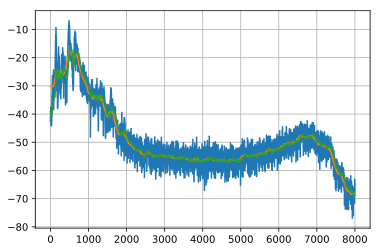

In [25]:
X_db, f = fft(data_scaled, fs)
X_db_roll, f1 = fft(data_scaled, fs, moving_average, fs//100)
X_db_smooth, f2 = fft(data_scaled, fs, exponential_smoothing, 0.02)

plt.plot(f, X_db)
plt.plot(f1, X_db_roll)
plt.plot(f2, X_db_smooth)
#plt.plot(np.log1p(f), X_db)
plt.grid()
plt.show()

In [27]:
def spectrum_feature(data, fs, signal_part):
    if (len(signal_part) == 0):
        window = np.hanning(data.shape[0])
        return fft(window*data, fs, moving_average, fs//100)

    N = data.shape[0]
    signal_data = np.ndarray((0,))
    for front, back in signal_part:
        window = np.hanning(back - front)
        signal_data = np.concatenate((signal_data, window*data[front:back]))

    return fft(signal_data, fs, moving_average, fs//100)

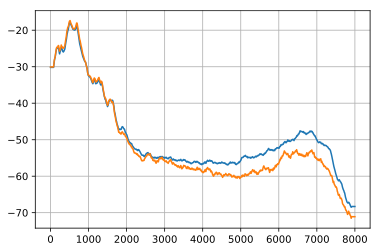

In [27]:
spec, freq = spectrum_feature(data_scaled, fs, signal_part)
X_db, f = fft(data_scaled, fs, moving_average, fs//100)

plt.plot(f, X_db)
plt.plot(freq, spec)
plt.grid();

In [28]:
def process(DIR, file_name):
    #print(file_name)
    fs, data = wavfile.read(path.join(DIR, file_name))
    data_scaled = scaler(data)
    signal_part = signal_detector(data_scaled, fs//10, fs//10, 10)
    spec, freq = spectrum_feature(data_scaled, fs, signal_part)
    return pd.Series(spec)

In [29]:
df_spec = pd.concat([df, pd.DataFrame(np.zeros((df.shape[0], FS//2)))], axis=1)
df_spec.head()

,File,Duration,Class,std_median,power_median,ratio,part_count,0,1,2,...,7990,7991,7992,7993,7994,7995,7996,7997,7998,7999
0,background_0001.wav,9.458500,background,1807.158625,416025.0,0.433473,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,background_0001_time_stretch_0.wav,9.989070,background,1951.477688,614656.0,0.405259,6.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,background_0001_time_stretch_1.wav,9.879410,background,1773.018809,485809.0,0.404699,6.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,background_0001_time_stretch_10.wav,11.156553,background,1935.027203,695556.0,0.403167,7.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,background_0001_time_stretch_11.wav,13.261587,background,1921.164951,732736.0,0.403238,7.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
df_test_spec = pd.concat([df_test, pd.DataFrame(np.zeros((df_test.shape[0], FS//2)))], axis=1)
df_test_spec.head()

,File,Class,std_median,power_median,ratio,part_count,0,1,2,3,...,7990,7991,7992,7993,7994,7995,7996,7997,7998,7999
0,background_0001.wav,background,5383.989258,13249600.0,0.993280,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,background_0004.wav,background,5047.828403,10876804.0,0.993873,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,background_0009.wav,background,4312.599896,7728400.0,0.991135,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,background_0012.wav,background,5104.766727,10890000.0,0.992625,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,background_0016.wav,background,4702.481588,9672100.0,0.994444,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [714]:
df_spec.iloc[:5, -8000:] = df_spec[:5].apply(lambda row: process(TRAIN_DIR, row['File']), axis=1)
df_spec.head(10)

,File,Duration,Class,std_median,power_median,ratio,part_count,0,1,2,...,7990,7991,7992,7993,7994,7995,7996,7997,7998,7999
0,background_0001.wav,9.458500,background,1807.158625,416025.0,0.433473,5.0,-8.691582,-8.691582,-8.691582,...,-21.111726,-21.111726,-21.111726,-21.111726,-21.111726,-21.111726,-21.111726,-21.111726,-21.111726,-21.111726
1,background_0001_time_stretch_0.wav,9.989070,background,1951.477688,614656.0,0.405259,6.0,-7.587257,-7.587257,-7.587257,...,-27.024458,-27.013207,-27.005294,-27.013965,-27.016695,-27.037670,-27.026955,-27.010780,-27.002297,-27.011377
2,background_0001_time_stretch_1.wav,9.879410,background,1773.018809,485809.0,0.404699,6.0,-8.358214,-8.358214,-8.358214,...,-29.911056,-29.917484,-29.922578,-29.942922,-29.945274,-29.951799,-29.963413,-29.968073,-29.983044,-29.967809
3,background_0001_time_stretch_10.wav,11.156553,background,1935.027203,695556.0,0.403167,7.0,-8.268729,-8.268729,-8.268729,...,-29.340171,-29.315319,-29.344365,-29.316184,-29.349354,-29.314801,-29.334117,-29.300616,-29.329766,-29.295357
4,background_0001_time_stretch_11.wav,13.261587,background,1921.164951,732736.0,0.403238,7.0,-8.331630,-8.331630,-8.331630,...,-28.331927,-28.294589,-28.329637,-28.318946,-28.288330,-28.306535,-28.323244,-28.303902,-28.343458,-28.321874
5,background_0001_time_stretch_12.wav,9.186440,background,1765.673962,506944.0,0.402585,7.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,background_0001_time_stretch_13.wav,8.117642,background,2087.614982,562500.0,0.455591,3.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,background_0001_time_stretch_2.wav,12.337098,background,1902.729568,724201.0,0.401047,6.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,background_0001_time_stretch_3.wav,12.455147,background,1910.188449,732736.0,0.405271,7.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,background_0001_time_stretch_4.wav,7.765306,background,2191.706506,648025.0,0.463390,3.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [31]:
%%time
df_spec.iloc[:, -8000:] = df_spec.apply(lambda row: process(TRAIN_DIR, row['File']), axis=1)

Wall time: 8min 3s


In [32]:
%%time
df_test_spec.iloc[:, -8000:] = df_test_spec.apply(lambda row: process(TEST_DIR, row['File']), axis=1)

Wall time: 23.9 s


In [46]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

X = df[['std_median', 'power_median', 'ratio', 'part_count']]

df_scaler = StandardScaler()
X_scaled = df_scaler.fit_transform(X)

In [68]:
%%time
tsne = TSNE(random_state=17)
tsne_representation = tsne.fit_transform(X_scaled)

Wall time: 5min 14s


In [73]:
d_color = {'background' : 'black',
     'bags' : 'green',
     'door' : 'red',
     'keyboard' : 'yellow',
     'knocking_door' : 'grey',
     'ring' : 'blue',
     'speech' : 'magenta',
     'tool' : 'violet'}

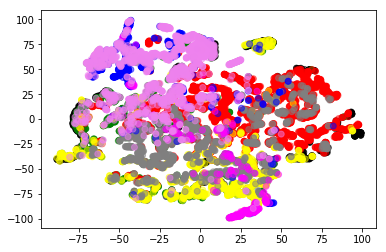

In [69]:
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1], c=df['Class'].map(d_color), alpha=0.5);

In [357]:
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)
df_poly_scaler = StandardScaler()
X_poly_scaled = df_poly_scaler.fit_transform(X_poly[:, 1:])

In [71]:
%%time
tsne = TSNE(random_state=17)
tsne_representation_poly = tsne.fit_transform(X_poly_scaled)

Wall time: 5min 16s


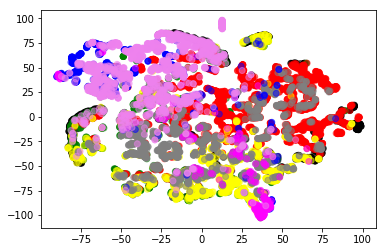

In [72]:
plt.scatter(tsne_representation_poly[:, 0], tsne_representation_poly[:, 1], c=df['Class'].map(d_color), alpha=0.5);

In [34]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.multiclass import OneVsRestClassifier

In [35]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

def cross_val(pipe, mode='oscilo'):
    '''
    mode = ['oscilo', 'spec', 'both']
    '''
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

    if (mode == 'oscilo'):
        X = df[['std_median', 'power_median', 'ratio', 'part_count']]
    elif (mode == 'spec'):
        X = df_spec.iloc[:, -8000:]
    else:
        X = df_spec.iloc[:, -8004:]
        
    y = df['Class'].map(d_class)

    return cross_val_score(pipe, X, y, cv=skf, scoring='accuracy', n_jobs=-1, verbose=True)

In [36]:
from sklearn.model_selection import GridSearchCV

def plot_grid_scores(grid, param_name):
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_train_score'], color='green', label='train')
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_test_score'], color='red', label='test')
    plt.legend();
    
def grid_serach(pipe, param_grid, param_name, mode='oscilo'):
    '''
    mode = ['oscilo', 'spec', 'both']
    '''
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

    if (mode == 'oscilo'):
        X = df[['std_median', 'power_median', 'ratio', 'part_count']]
    elif (mode == 'spec'):
        X = df_spec.iloc[:, -8000:]
    else:
        X = df_spec.iloc[:, -8004:]
        
    y = df['Class'].map(d_class)

    grid_pipe = GridSearchCV(pipe, param_grid, cv=skf, n_jobs=-1, return_train_score=True)

    grid_pipe.fit(X, y)
    plot_grid_scores(grid_pipe, param_name)
    
    return grid_pipe.best_params_, grid_pipe.best_score_

In [351]:
lg_pipe = Pipeline([('scaler', StandardScaler()), 
                    ('logit', LogisticRegression(C=4, penalty='l2', solver='lbfgs', multi_class='multinomial',
                                                 n_jobs=1, random_state=17))])

cross_val(lg_pipe)

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.3s finished


array([ 0.60326567,  0.60415745,  0.62229102,  0.62168142,  0.61443116])

({'logit__C': 4.0}, 0.61315998938710536)

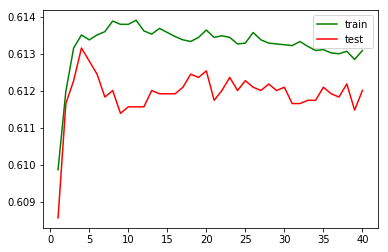

In [355]:
lg_pipe = Pipeline([('scaler', StandardScaler()), 
                    ('logit', LogisticRegression(C=1, penalty='l2', solver='lbfgs', multi_class='multinomial',
                                                 n_jobs=1, random_state=17))])

grid_serach(lg_pipe, {'logit__C': np.linspace(1, 40, 40)}, 'logit__C')

In [36]:
X = df[['std_median', 'power_median', 'ratio', 'part_count']]
y = df['Class'].map(d_class)

test_close_index = df_test['Class'] != 'unknown'
X_test_close = (df_test[test_close_index])[['std_median', 'power_median', 'ratio', 'part_count']]
y_test_close = (df_test[test_close_index])['Class'].map(d_class)

df_scaler = StandardScaler()
X_scaled = df_scaler.fit_transform(X)
X_test_close_scaled = df_scaler.transform(X_test_close)

logit = LogisticRegression(C=4, penalty='l2', solver='lbfgs', multi_class='multinomial', n_jobs=1, random_state=17)
logit.fit(X_scaled, y)
cls = logit.predict(X_test_close_scaled)
proba = logit.predict_proba(X_test_close_scaled)

print(accuracy_score(y_test_close, cls))
cfm = confusion_matrix(cls, y_test_close)
pd.DataFrame(np.vstack((cfm, cfm.sum(axis=0), [round(cfm[i, i] / cfm.sum(axis=0)[i], ndigits=2) for i in range(cfm.shape[0])])),
             index=list(d_class.keys())[:-1] + ['Total', 'Recall'],
             columns=[str[:4] for str in list(d_class.keys())[:-1]])

0.344608879493


,back,bags,door,keyb,knoc,ring,spee,tool
background,1.00,1.00,1.00,0.00,0.00,4.00,0.00,0.00
bags,21.00,23.00,0.00,0.00,1.00,3.00,27.00,0.00
door,0.00,11.00,36.00,0.00,19.00,36.00,26.00,0.00
keyboard,8.00,10.00,2.00,39.00,6.00,3.00,4.00,0.00
knocking_door,3.00,5.00,10.00,8.00,33.00,8.00,46.00,0.00
ring,0.00,0.00,0.00,0.00,0.00,13.00,2.00,2.00
speech,0.00,0.00,0.00,0.00,0.00,1.00,6.00,0.00
tool,8.00,0.00,0.00,0.00,0.00,4.00,30.00,12.00
Total,41.00,50.00,49.00,47.00,59.00,72.00,141.00,14.00
Recall,0.02,0.46,0.73,0.83,0.56,0.18,0.04,0.86


In [37]:
lg_pipe = Pipeline([('poly', PolynomialFeatures(degree=2)),
                    ('scaler', StandardScaler()),
                    #('pca', PCA(n_components=0.9)),
                    #('scaler2', StandardScaler()),
                    ('logit', LogisticRegression(C=1, penalty='l2', solver='lbfgs', multi_class='multinomial',
                                                 n_jobs=1, random_state=17))])

cross_val(lg_pipe)

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.1s finished


array([ 0.64872021,  0.64307828,  0.66430783,  0.65132743,  0.65205843])

({'logit__C': 27.0}, 0.65853011408861772)

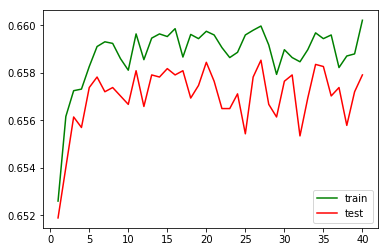

In [361]:
lg_pipe = Pipeline([('poly', PolynomialFeatures(degree=2)),
                    ('scaler', StandardScaler()),
                    ('logit', LogisticRegression(C=1, penalty='l2', solver='lbfgs', multi_class='multinomial',
                                                 n_jobs=1, random_state=17))])

grid_serach(lg_pipe, {'logit__C': np.linspace(1, 40, 40)}, 'logit__C')

({'poly__degree': 7}, 0.70805695586804629)

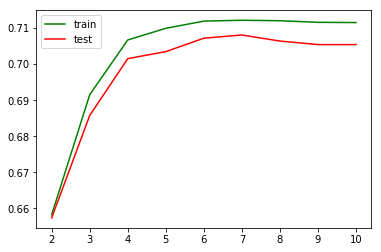

In [363]:
lg_pipe = Pipeline([('poly', PolynomialFeatures(degree=2)),
                    ('scaler', StandardScaler()),
                    ('logit', LogisticRegression(C=5, penalty='l2', solver='lbfgs', multi_class='multinomial',
                                                 n_jobs=1, random_state=17))])

grid_serach(lg_pipe, {'poly__degree': np.linspace(2, 10, 9, dtype='int')}, 'poly__degree')

In [38]:
X = df[['std_median', 'power_median', 'ratio', 'part_count']]
y = df['Class'].map(d_class)

test_close_index = df_test['Class'] != 'unknown'
X_test_close = (df_test[test_close_index])[['std_median', 'power_median', 'ratio', 'part_count']]
y_test_close = (df_test[test_close_index])['Class'].map(d_class)

poly = PolynomialFeatures(degree=4)
X_poly = poly.fit_transform(X)
X_test_close_poly = poly.transform(X_test_close)

df_scaler = StandardScaler()
X_poly_scaled = df_scaler.fit_transform(X_poly)
X_test_close_poly_scaled = df_scaler.transform(X_test_close_poly)

logit = LogisticRegression(C=5, penalty='l2', solver='lbfgs', multi_class='multinomial', n_jobs=1, random_state=17)
logit.fit(X_poly_scaled, y)
cls = logit.predict(X_test_close_poly_scaled)
proba = logit.predict_proba(X_test_close_poly_scaled)

print(accuracy_score(y_test_close, cls))
cfm = confusion_matrix(cls, y_test_close)
pd.DataFrame(np.vstack((cfm, cfm.sum(axis=0), [round(cfm[i, i] / cfm.sum(axis=0)[i], ndigits=2) for i in range(cfm.shape[0])])),
             index=list(d_class.keys())[:-1] + ['Total', 'Recall'],
             columns=[str[:4] for str in list(d_class.keys())[:-1]])

0.498942917548


,back,bags,door,keyb,knoc,ring,spee,tool
background,19.00,5.00,1.00,5.00,0.00,12.00,1.00,0.00
bags,10.00,26.00,2.00,1.00,1.00,6.00,2.00,0.00
door,0.00,9.00,40.00,0.00,18.00,27.00,26.00,2.00
keyboard,5.00,8.00,2.00,34.00,6.00,0.00,6.00,0.00
knocking_door,2.00,2.00,4.00,7.00,34.00,6.00,26.00,0.00
ring,0.00,0.00,0.00,0.00,0.00,10.00,17.00,1.00
speech,0.00,0.00,0.00,0.00,0.00,1.00,62.00,0.00
tool,5.00,0.00,0.00,0.00,0.00,10.00,1.00,11.00
Total,41.00,50.00,49.00,47.00,59.00,72.00,141.00,14.00
Recall,0.46,0.52,0.82,0.72,0.58,0.14,0.44,0.79


In [107]:
rg_pipe = Pipeline([('scaler', StandardScaler()), 
                    ('ovr', OneVsRestClassifier(Ridge(alpha=1, solver='auto', random_state=17)))])

cross_val(rg_pipe)

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


array([ 0.47352162,  0.4763379 ,  0.4789916 ,  0.49115044,  0.47011952])

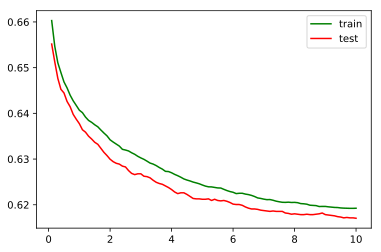

In [77]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

X = (df[['std_median', 'power_median', 'ratio', 'part_count']]).values
y = df['Class'].map(d_class).values

train_acc = []
valid_acc = []
param_range = np.linspace(0.1, 10, 100)
for param in param_range:
    train_acc_curr = []
    valid_acc_curr = []
    for train_idx, test_idx  in skf.split(X, y):
        rg_pipe = Pipeline([('poly', PolynomialFeatures(degree=4)),
                            ('scaler', StandardScaler()), 
                            ('ovr', OneVsRestClassifier(Ridge(alpha=param, solver='auto', random_state=17)))])
        rg_pipe.fit(X[train_idx], y[train_idx]);
        train_acc_curr.append(accuracy_score(y[train_idx], rg_pipe.predict(X[train_idx])))
        valid_acc_curr.append(accuracy_score(y[test_idx], rg_pipe.predict(X[test_idx])))
    train_acc.append(np.mean(train_acc_curr))
    valid_acc.append(np.mean(valid_acc_curr))

plt.plot(param_range, train_acc, color='green', label='train')
plt.plot(param_range, valid_acc, color='red', label='test')
plt.legend();

In [109]:
ls_pipe = Pipeline([('scaler', StandardScaler()), 
                    ('ovr', OneVsRestClassifier(Lasso(alpha=1, random_state=17)))])

cross_val(ls_pipe)

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


array([ 0.30185349,  0.30207873,  0.30207873,  0.30221239,  0.30234617])

In [365]:
svc_pipe = Pipeline([('scaler', StandardScaler()), 
                     ('svc', SVC(C=1.0, kernel='rbf', gamma='auto',
                                 decision_function_shape='ovr', random_state=17))])

cross_val(svc_pipe)

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.1s finished


array([ 0.68225949,  0.67757629,  0.68774878,  0.68982301,  0.68083223])

({'svc__C': 20.0}, 0.71442469266825859)

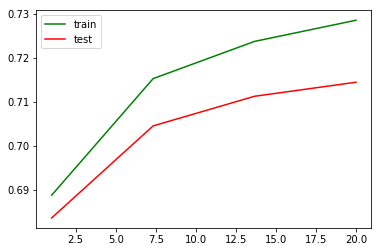

In [377]:
svc_pipe = Pipeline([('scaler', StandardScaler()), 
                     ('svc', SVC(C=1, kernel='rbf', gamma='auto',
                                 decision_function_shape='ovr', random_state=17))])

grid_serach(svc_pipe, {'svc__C': np.linspace(1, 20, 4)}, 'svc__C')

({'svc__gamma': 1.0}, 0.7360926859467587)

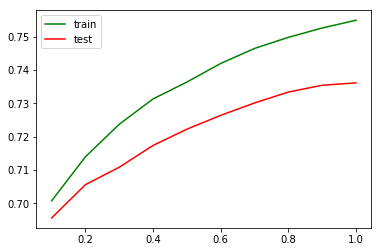

In [369]:
svc_pipe = Pipeline([('scaler', StandardScaler()), 
                     ('svc', SVC(C=10, kernel='rbf', gamma='auto',
                                 decision_function_shape='ovr', random_state=17))])

grid_serach(svc_pipe, {'svc__gamma': np.linspace(0.1, 1, 10)}, 'svc__gamma')

In [374]:
X = df[['std_median', 'power_median', 'ratio', 'part_count']]
y = df['Class'].map(d_class)

test_close_index = df_test['Class'] != 'unknown'
X_test_close = (df_test[test_close_index])[['std_median', 'power_median', 'ratio', 'part_count']]
y_test_close = (df_test[test_close_index])['Class'].map(d_class)

df_scaler = StandardScaler()
X_scaled = df_scaler.fit_transform(X)
X_test_close_scaled = df_scaler.transform(X_test_close)

svc = SVC(C=10, kernel='rbf', gamma=0.6, decision_function_shape='ovr', random_state=17, probability=True)
svc.fit(X_scaled, y)
cls = svc.predict(X_test_close_scaled)
proba = svc.predict_proba(X_test_close_scaled)

print(accuracy_score(y_test_close, cls))
cfm = confusion_matrix(cls, y_test_close)
pd.DataFrame(np.vstack((cfm, cfm.sum(axis=0), [round(cfm[i, i] / cfm.sum(axis=0)[i], ndigits=2) for i in range(cfm.shape[0])])),
             index=list(d_class.keys())[:-1] + ['Total', 'Recall'],
             columns=[str[:4] for str in list(d_class.keys())[:-1]])

0.524312896406


,back,bags,door,keyb,knoc,ring,spee,tool
background,19.00,5.00,1.00,2.00,0.00,5.00,7.00,0.00
bags,8.00,27.00,2.00,0.00,1.00,9.00,3.00,0.00
door,0.00,6.00,41.00,0.00,22.00,10.00,22.00,1.00
keyboard,5.00,10.00,3.00,39.00,6.00,3.00,4.00,0.00
knocking_door,3.00,2.00,2.00,6.00,30.00,9.00,34.00,0.00
ring,0.00,0.00,0.00,0.00,0.00,26.00,10.00,2.00
speech,0.00,0.00,0.00,0.00,0.00,0.00,55.00,0.00
tool,6.00,0.00,0.00,0.00,0.00,10.00,6.00,11.00
Total,41.00,50.00,49.00,47.00,59.00,72.00,141.00,14.00
Recall,0.46,0.54,0.84,0.83,0.51,0.36,0.39,0.79


In [375]:
svc_pipe = Pipeline([('poly', PolynomialFeatures(degree=2)),
                     ('scaler', StandardScaler()), 
                     ('svc', SVC(C=1.0, kernel='rbf', gamma='auto',
                                 decision_function_shape='ovr', random_state=17))])

cross_val(svc_pipe)

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.8s finished


array([ 0.67696381,  0.67403804,  0.68022999,  0.68318584,  0.67242143])

({'svc__C': 100.0}, 0.7322012912355178)

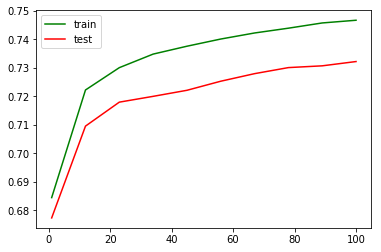

In [378]:
svc_pipe = Pipeline([('poly', PolynomialFeatures(degree=2)),
                     ('scaler', StandardScaler()), 
                     ('svc', SVC(C=1.0, kernel='rbf', gamma='auto',
                                 decision_function_shape='ovr', random_state=17))])

grid_serach(svc_pipe, {'svc__C': np.linspace(1, 100, 10)}, 'svc__C')

({'svc__gamma': 2.0}, 0.76740072521446889)

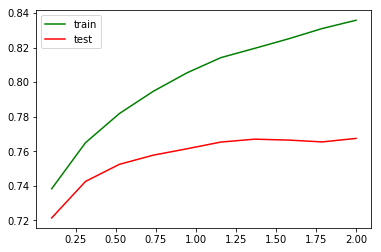

In [379]:
svc_pipe = Pipeline([('poly', PolynomialFeatures(degree=2)),
                     ('scaler', StandardScaler()), 
                     ('svc', SVC(C=20, kernel='rbf', gamma='auto',
                                 decision_function_shape='ovr', random_state=17))])

grid_serach(svc_pipe, {'svc__gamma': np.linspace(0.1, 2, 10)}, 'svc__gamma')

({'poly__degree': 4}, 0.75820288316971785)

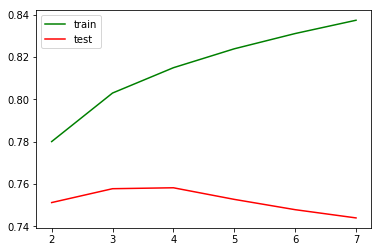

In [381]:
svc_pipe = Pipeline([('poly', PolynomialFeatures(degree=2)),
                     ('scaler', StandardScaler()), 
                     ('svc', SVC(C=20, kernel='rbf', gamma=0.5,
                                 decision_function_shape='ovr', random_state=17))])

grid_serach(svc_pipe, {'poly__degree': np.linspace(2, 7, 6, dtype='int')}, 'poly__degree')

In [383]:
X = df[['std_median', 'power_median', 'ratio', 'part_count']]
y = df['Class'].map(d_class)

test_close_index = df_test['Class'] != 'unknown'
X_test_close = (df_test[test_close_index])[['std_median', 'power_median', 'ratio', 'part_count']]
y_test_close = (df_test[test_close_index])['Class'].map(d_class)

poly = PolynomialFeatures(degree=4)
X_poly = poly.fit_transform(X)
X_test_close_poly = poly.transform(X_test_close)

df_scaler = StandardScaler()
X_poly_scaled = df_scaler.fit_transform(X_poly)
X_test_close_poly_scaled = df_scaler.transform(X_test_close_poly)

svc = SVC(C=20, kernel='rbf', gamma=0.5, decision_function_shape='ovr', random_state=17, probability=True)
svc.fit(X_poly_scaled, y)
cls = svc.predict(X_test_close_poly_scaled)
proba = svc.predict_proba(X_test_close_poly_scaled)

print(accuracy_score(y_test_close, cls))
cfm = confusion_matrix(cls, y_test_close)
pd.DataFrame(np.vstack((cfm, cfm.sum(axis=0), [round(cfm[i, i] / cfm.sum(axis=0)[i], ndigits=2) for i in range(cfm.shape[0])])),
             index=list(d_class.keys())[:-1] + ['Total', 'Recall'],
             columns=[str[:4] for str in list(d_class.keys())[:-1]])

0.547568710359


,back,bags,door,keyb,knoc,ring,spee,tool
background,15.00,1.00,1.00,0.00,0.00,3.00,7.00,0.00
bags,13.00,32.00,1.00,2.00,3.00,9.00,3.00,1.00
door,0.00,3.00,41.00,1.00,23.00,7.00,14.00,0.00
keyboard,4.00,13.00,4.00,39.00,5.00,5.00,4.00,0.00
knocking_door,2.00,1.00,2.00,5.00,27.00,9.00,24.00,0.00
ring,0.00,0.00,0.00,0.00,0.00,31.00,15.00,0.00
speech,0.00,0.00,0.00,0.00,1.00,0.00,61.00,0.00
tool,7.00,0.00,0.00,0.00,0.00,8.00,13.00,13.00
Total,41.00,50.00,49.00,47.00,59.00,72.00,141.00,14.00
Recall,0.37,0.64,0.84,0.83,0.46,0.43,0.43,0.93


In [392]:
fr_pipe = Pipeline([('ovr', OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=17)))])

cross_val(fr_pipe)

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   39.0s finished


array([ 0.82700794,  0.84387439,  0.83325962,  0.84159292,  0.83709606])

In [84]:
X = df[['std_median', 'power_median', 'ratio', 'part_count']]
y = df['Class'].map(d_class)

test_close_index = df_test['Class'] != 'unknown'
X_test_close = (df_test[test_close_index])[['std_median', 'power_median', 'ratio', 'part_count']]
y_test_close = (df_test[test_close_index])['Class'].map(d_class)

ovr = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=17))
ovr.fit(X, y)
cls = ovr.predict(X_test_close)
proba = ovr.predict_proba(X_test_close)

print(accuracy_score(y_test_close, cls))
cfm = confusion_matrix(cls, y_test_close)
pd.DataFrame(np.vstack((cfm, cfm.sum(axis=0), [round(cfm[i, i] / cfm.sum(axis=0)[i], ndigits=2) for i in range(cfm.shape[0])])),
             index=list(d_class.keys())[:-1] + ['Total', 'Recall'],
             columns=[str[:4] for str in list(d_class.keys())[:-1]])

0.615221987315


,back,bags,door,keyb,knoc,ring,spee,tool
background,11.00,1.00,2.00,0.00,0.00,3.00,9.0,0.0
bags,18.00,32.00,1.00,6.00,3.00,2.00,7.0,0.0
door,0.00,8.00,41.00,0.00,22.00,2.00,19.0,0.0
keyboard,2.00,8.00,4.00,37.00,7.00,0.00,3.0,0.0
knocking_door,2.00,1.00,1.00,4.00,26.00,0.00,17.0,0.0
ring,0.00,0.00,0.00,0.00,0.00,60.00,9.0,0.0
speech,0.00,0.00,0.00,0.00,1.00,2.00,70.0,0.0
tool,8.00,0.00,0.00,0.00,0.00,3.00,7.0,14.0
Total,41.00,50.00,49.00,47.00,59.00,72.00,141.0,14.0
Recall,0.27,0.64,0.84,0.79,0.44,0.83,0.5,1.0


In [404]:
fr_pipe = Pipeline([('poly', PolynomialFeatures(degree=4)),
                     ('ovr', OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=17, n_jobs=-1)))])

cross_val(fr_pipe)

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.3min finished


array([ 0.83495146,  0.84077842,  0.84077842,  0.83938053,  0.83842408])

In [405]:
fr_pipe = Pipeline([('poly', PolynomialFeatures(degree=4)),
                     ('ovr', OneVsRestClassifier(RandomForestClassifier(n_estimators=500, random_state=17, n_jobs=-1)))])

cross_val(fr_pipe)

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.6min finished


array([ 0.83318623,  0.84475896,  0.84033613,  0.84115044,  0.8397521 ])

In [83]:
X = df[['std_median', 'power_median', 'ratio', 'part_count']]
y = df['Class'].map(d_class)

test_close_index = df_test['Class'] != 'unknown'
X_test_close = (df_test[test_close_index])[['std_median', 'power_median', 'ratio', 'part_count']]
y_test_close = (df_test[test_close_index])['Class'].map(d_class)

poly = PolynomialFeatures(degree=4)
X_poly = poly.fit_transform(X)
X_test_close_poly = poly.transform(X_test_close)

ovr = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=17, n_jobs=-1))
ovr.fit(X_poly, y)
cls = ovr.predict(X_test_close_poly)
proba = ovr.predict_proba(X_test_close_poly)

print(accuracy_score(y_test_close, cls))
cfm = confusion_matrix(cls, y_test_close)
pd.DataFrame(np.vstack((cfm, cfm.sum(axis=0), [round(cfm[i, i] / cfm.sum(axis=0)[i], ndigits=2) for i in range(cfm.shape[0])])),
             index=list(d_class.keys())[:-1] + ['Total', 'Recall'],
             columns=[str[:4] for str in list(d_class.keys())[:-1]])

0.61733615222


,back,bags,door,keyb,knoc,ring,spee,tool
background,9.00,1.00,1.00,1.00,0.00,3.00,8.00,0.0
bags,21.00,34.00,1.00,4.00,2.00,2.00,8.00,0.0
door,0.00,4.00,38.00,1.00,22.00,2.00,15.00,0.0
keyboard,1.00,6.00,4.00,39.00,8.00,0.00,2.00,0.0
knocking_door,2.00,4.00,5.00,2.00,26.00,0.00,17.00,0.0
ring,0.00,0.00,0.00,0.00,0.00,59.00,10.00,0.0
speech,0.00,0.00,0.00,0.00,1.00,1.00,73.00,0.0
tool,8.00,1.00,0.00,0.00,0.00,5.00,8.00,14.0
Total,41.00,50.00,49.00,47.00,59.00,72.00,141.00,14.0
Recall,0.22,0.68,0.78,0.83,0.44,0.82,0.52,1.0


In [102]:
fr_pipe = Pipeline([('ovr', OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=17, n_jobs=-1)))])

cross_val(fr_pipe, mode='spec')

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 26.9min finished


array([ 0.96028244,  0.95134896,  0.96373286,  0.95486726,  0.96193006])

In [ ]:
gb_pipe = Pipeline([('ovr', OneVsRestClassifier(GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=17)))])

cross_val(gb_pipe, mode='spec')

In [95]:
lg_pipe = Pipeline([('scaler', StandardScaler()), 
                    ('logit', LogisticRegression(C=4, penalty='l2', solver='lbfgs', multi_class='multinomial',
                                                 n_jobs=1, random_state=17))])

cross_val(lg_pipe, mode='spec')

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.5min finished


array([ 0.81862312,  0.8261831 ,  0.82264485,  0.80619469,  0.82204515])

In [100]:
rg_pipe = Pipeline([('scaler', StandardScaler()), 
                    ('ovr', OneVsRestClassifier(Ridge(alpha=1, solver='auto', random_state=17)))])

cross_val(rg_pipe, mode='spec')

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  9.8min finished


array([ 0.86451898,  0.85050862,  0.84962406,  0.84690265,  0.85347499])

In [108]:
ls_pipe = Pipeline([('scaler', StandardScaler()), 
                    ('ovr', OneVsRestClassifier(Lasso(alpha=1, random_state=17)))])

cross_val(ls_pipe, mode='spec')

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.5min finished


array([ 0.30185349,  0.30207873,  0.30207873,  0.30221239,  0.30234617])

In [101]:
svc_pipe = Pipeline([('scaler', StandardScaler()), 
                     ('svc', SVC(C=1.0, kernel='rbf', gamma='auto',
                                 decision_function_shape='ovr', random_state=17))])

cross_val(svc_pipe, mode='spec')

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 24.3min finished


array([ 0.880406  ,  0.88633348,  0.89694825,  0.87743363,  0.88888889])

In [37]:
fr_pipe = Pipeline([('ovr', OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=17, n_jobs=-1)))])

cross_val(fr_pipe, mode='both')

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 15.7min finished


array([ 0.96248897,  0.95842548,  0.96550199,  0.95530973,  0.96502877])

In [94]:
X = df_spec.iloc[:,-8004:]
y = df_spec['Class'].map(d_class)

test_close_index = df_test_spec['Class'] != 'unknown'
X_test_close = (df_test_spec[test_close_index]).iloc[:,-8004:]
y_test_close = (df_test_spec[test_close_index])['Class'].map(d_class)

rfc = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=17, n_jobs=-1))
rfc.fit(X, y)
rfc_cls = rfc.predict(X_test_close)
rfc_proba = rfc.predict_proba(X_test_close)

print(accuracy_score(y_test_close, rfc_cls))
rfc_cfm = confusion_matrix(rfc_cls, y_test_close)
pd.DataFrame(np.vstack((rfc_cfm, rfc_cfm.sum(axis=0),
                        [round(rfc_cfm[i, i] / rfc_cfm.sum(axis=0)[i], ndigits=2) for i in range(rfc_cfm.shape[0])])),
             index=list(d_class.keys())[:-1] + ['Total', 'Recall'],
             columns=[str[:4] for str in list(d_class.keys())[:-1]])

0.799154334038


,back,bags,door,keyb,knoc,ring,spee,tool
background,25.00,0.0,3.00,1.00,3.00,0.00,7.00,0.0
bags,0.00,40.0,6.00,4.00,0.00,0.00,0.00,0.0
door,0.00,7.0,34.00,3.00,6.00,0.00,4.00,0.0
keyboard,1.00,1.0,2.00,24.00,0.00,0.00,0.00,0.0
knocking_door,1.00,0.0,0.00,0.00,49.00,0.00,3.00,0.0
ring,0.00,0.0,0.00,0.00,0.00,71.00,0.00,0.0
speech,0.00,0.0,0.00,0.00,0.00,0.00,121.00,0.0
tool,14.00,2.0,4.00,15.00,1.00,1.00,6.00,14.0
Total,41.00,50.0,49.00,47.00,59.00,72.00,141.00,14.0
Recall,0.61,0.8,0.69,0.51,0.83,0.99,0.86,1.0


In [ ]:
gb_pipe = Pipeline([('ovr', OneVsRestClassifier(GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=17)))])

cross_val(gb_pipe, mode='both')

In [43]:
X = df_spec.iloc[:,-8004:]
y = df_spec['Class'].map(d_class)

test_close_index = df_test_spec['Class'] != 'unknown'
X_test_close = (df_test_spec[test_close_index]).iloc[:,-8004:]
y_test_close = (df_test_spec[test_close_index])['Class'].map(d_class)

ovr = OneVsRestClassifier(GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=17))
ovr.fit(X, y)
cls = ovr.predict(X_test_close)
proba = ovr.predict_proba(X_test_close)

print(accuracy_score(y_test_close, cls))
cfm = confusion_matrix(cls, y_test_close)
pd.DataFrame(np.vstack((cfm, cfm.sum(axis=0), [round(cfm[i, i] / cfm.sum(axis=0)[i], ndigits=2) for i in range(cfm.shape[0])])),
             index=list(d_class.keys())[:-1] + ['Total', 'Recall'],
             columns=[str[:4] for str in list(d_class.keys())[:-1]])

0.792811839323


,back,bags,door,keyb,knoc,ring,spee,tool
background,16.00,0.00,5.00,3.00,3.00,0.00,13.00,0.0
bags,0.00,41.00,0.00,1.00,0.00,0.00,0.00,0.0
door,0.00,4.00,41.00,3.00,10.00,2.00,7.00,0.0
keyboard,4.00,2.00,1.00,40.00,1.00,0.00,0.00,0.0
knocking_door,1.00,0.00,0.00,0.00,45.00,0.00,4.00,0.0
ring,0.00,0.00,0.00,0.00,0.00,70.00,1.00,0.0
speech,0.00,0.00,1.00,0.00,0.00,0.00,108.00,0.0
tool,20.00,3.00,1.00,0.00,0.00,0.00,8.00,14.0
Total,41.00,50.00,49.00,47.00,59.00,72.00,141.00,14.0
Recall,0.39,0.82,0.84,0.85,0.76,0.97,0.77,1.0


({'svc__C': 20.0}, 0.97877421066595915)

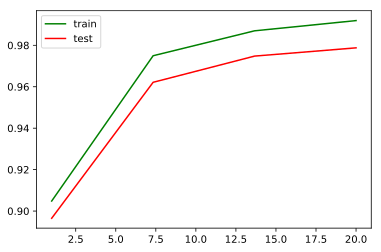

In [38]:
svc_pipe = Pipeline([('scaler', StandardScaler()), 
                     ('svc', SVC(C=1, kernel='rbf', gamma='auto',
                                 decision_function_shape='ovr', random_state=17))])

grid_serach(svc_pipe, {'svc__C': np.linspace(1, 20, 4)}, 'svc__C', 'both')

In [38]:
svc_pipe = Pipeline([('scaler', StandardScaler()), 
                     ('svc', SVC(C=10, kernel='rbf', gamma='auto',
                                 decision_function_shape='ovr', random_state=17))])

cross_val(svc_pipe, mode='both')

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  8.7min finished


array([ 0.97263901,  0.96948253,  0.97125166,  0.9619469 ,  0.97388225])

In [39]:
X = df_spec.iloc[:,-8004:]
y = df_spec['Class'].map(d_class)

test_close_index = df_test_spec['Class'] != 'unknown'
X_test_close = (df_test_spec[test_close_index]).iloc[:,-8004:]
y_test_close = (df_test_spec[test_close_index])['Class'].map(d_class)

df_scaler = StandardScaler()
X_scaled = df_scaler.fit_transform(X)
X_test_close_scaled = df_scaler.transform(X_test_close)

svc = SVC(C=10, kernel='rbf', gamma='auto', decision_function_shape='ovr', random_state=17, probability=True)
svc.fit(X_scaled, y)
svc_cls = svc.predict(X_test_close_scaled)
svc_proba = svc.predict_proba(X_test_close_scaled)

print(accuracy_score(y_test_close, svc_cls))
svc_cfm = confusion_matrix(svc_cls, y_test_close)
pd.DataFrame(np.vstack((svc_cfm, svc_cfm.sum(axis=0),
                        [round(svc_cfm[i, i] / svc_cfm.sum(axis=0)[i], ndigits=2) for i in range(svc_cfm.shape[0])])),
             index=list(d_class.keys())[:-1] + ['Total', 'Recall'],
             columns=[str[:4] for str in list(d_class.keys())[:-1]])

0.832980972516


,back,bags,door,keyb,knoc,ring,spee,tool
background,39.00,0.00,4.00,0.00,4.00,4.00,5.00,0.00
bags,0.00,49.00,4.00,4.00,0.00,0.00,0.00,0.00
door,0.00,0.00,33.00,3.00,7.00,1.00,6.00,2.00
keyboard,1.00,1.00,1.00,29.00,0.00,0.00,0.00,0.00
knocking_door,0.00,0.00,0.00,0.00,43.00,0.00,2.00,1.00
ring,0.00,0.00,0.00,0.00,0.00,67.00,1.00,0.00
speech,0.00,0.00,2.00,0.00,4.00,0.00,123.00,0.00
tool,1.00,0.00,5.00,11.00,1.00,0.00,4.00,11.00
Total,41.00,50.00,49.00,47.00,59.00,72.00,141.00,14.00
Recall,0.95,0.98,0.67,0.62,0.73,0.93,0.87,0.79


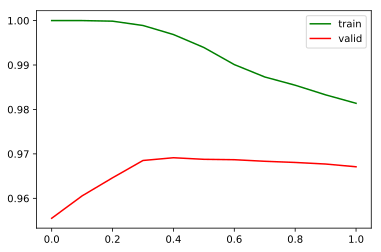

In [40]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

X = df_spec.iloc[:,-8004:].values
y = df_spec['Class'].map(d_class).values

train_acc = {}
valid_acc = {}  
for alpha in np.linspace(0.0, 1.0, 11):
    train_acc[alpha] = []
    valid_acc[alpha] = []

for train_idx, valid_idx  in skf.split(X, y):
    X_train, y_train = X[train_idx], y[train_idx]
    X_valid, y_valid = X[valid_idx], y[valid_idx]

    svc_scaler = StandardScaler()
    X_train_scaled = svc_scaler.fit_transform(X_train)
    X_valid_scaled = svc_scaler.transform(X_valid)

    svc = SVC(C=10, kernel='rbf', gamma='auto', decision_function_shape='ovr', random_state=17, probability=True)
    svc.fit(X_train_scaled, y_train)
    svc_train_proba = svc.predict_proba(X_train_scaled)
    svc_valid_proba = svc.predict_proba(X_valid_scaled)

    rfc = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=17, n_jobs=-1))
    rfc.fit(X_train, y_train)
    rfc_train_proba = rfc.predict_proba(X_train)
    rfc_valid_proba = rfc.predict_proba(X_valid)

    '''
    gbc = OneVsRestClassifier(GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=17))
    gbc.fit(X_train, y_train)
    gbc_train_proba = gbc.predict_proba(X_train)
    gbc_valid_proba = gbc.predict_proba(X_valid)
    '''

    for alpha in np.linspace(0.0, 1.0, 11):
        proba_train = alpha*svc_train_proba + (1.0 - alpha)*rfc_train_proba
        proba_valid = alpha*svc_valid_proba + (1.0 - alpha)*rfc_valid_proba
        
        train_acc[alpha].append(accuracy_score(y_train, [np.argmax(probas) for probas in proba_train]))
        valid_acc[alpha].append(accuracy_score(y_valid, [np.argmax(probas) for probas in proba_valid]))
        '''
        for beta in np.linspace(0.0, 1.0, 11):
            proba_train = beta*(alpha*svc_train_proba + (1.0 - aplha)*rfc_train_proba) + (1.0 - beta)*gbc_train_proba
            proba_valid = beta*(alpha*svc_valid_proba + (1.0 - aplha)*rfc_valid_proba) + (1.0 - beta)*gbc_valid_proba
        '''
        
plt.plot(train_acc.keys(), [np.mean(acc) for acc in train_acc.values()], color='green', label='train')
plt.plot(valid_acc.keys(), [np.mean(acc) for acc in valid_acc.values()], color='red',   label='valid')
plt.legend();

In [50]:
print('Best alpha = %.1f' % list(valid_acc.keys())[np.argmax([np.mean(acc) for acc in valid_acc.values()])])

Best alpha = 0.4
